**Module-1:Data Import and EDA**

#Importing Data




In [19]:
import pandas as pd

df = pd.read_csv(
    "/content/german.data",
    sep=r"\s+",
    header=None
)

df.to_csv("raw.csv", index=False)


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/raw.csv")

df.shape


(1000, 21)

##adding column names


In [21]:
columns = [
    "status", "duration", "credit_history", "purpose", "credit_amount",
    "savings", "employment", "installment_rate", "personal_status_sex",
    "other_debtors", "residence_since", "property", "age",
    "other_installment_plans", "housing", "existing_credits",
    "job", "num_dependents", "telephone", "foreign_worker",
    "credit_risk"
]

df.columns = columns


##target conversion

In [22]:
df["default"] = df["credit_risk"].map({1: 0, 2: 1})
df.drop("credit_risk", axis=1, inplace=True)


### checking for missing values


In [23]:
df.isnull().sum()

,0
status,0
duration,0
credit_history,0
purpose,0
credit_amount,0
savings,0
employment,0
installment_rate,0
personal_status_sex,0
other_debtors,0


###The Statlog German Credit dataset was sourced from the UCI Machine Learning Repository and imported in its original categorical format. As the raw data file does not contain header information and uses whitespace as a delimiter, the dataset was read accordingly and appropriate column names were assigned based on the official documentation provided with the dataset.

###The original credit risk indicator was transformed into a binary target variable to represent loan default status, where non-default cases were encoded as 0 and default cases as 1. No observations were excluded during the data import stage in order to retain the original structure and distribution of the dataset. This step ensures data integrity and provides a consistent foundation for subsequent exploratory data analysis and feature engineering procedures.

#EDA

*Univariate Analysis*

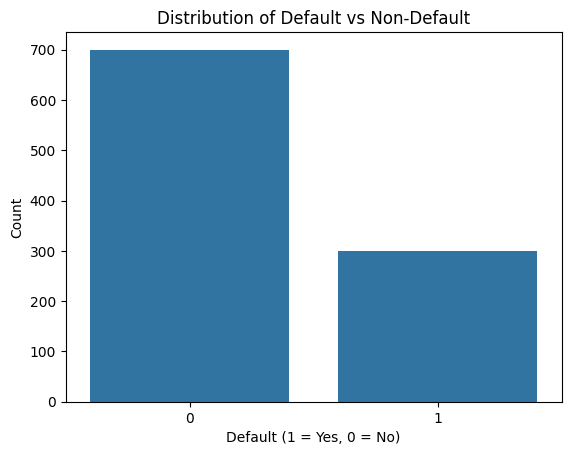

In [24]:
#Target Variable Distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="default", data=df)
plt.title("Distribution of Default vs Non-Default")
plt.xlabel("Default (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()


###The dataset exhibits a moderate class imbalance, with non-default cases forming the majority. This reflects real-world credit portfolios and justifies the use of evaluation metrics such as ROC-AUC rather than accuracy alone.

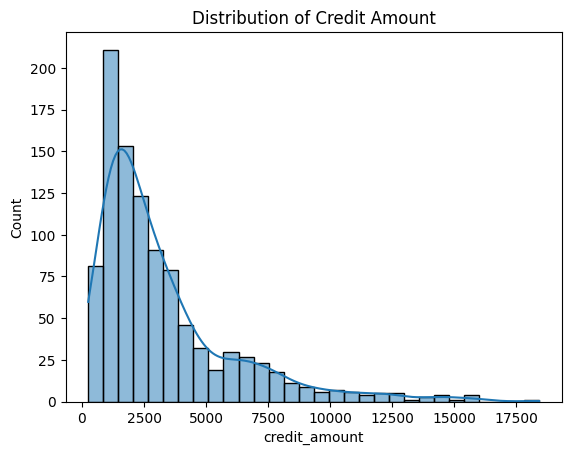

In [25]:
#Credit Amount Distribution
sns.histplot(df["credit_amount"], bins=30, kde=True)
plt.title("Distribution of Credit Amount")
plt.show()


###Credit amounts show a right-skewed distribution, indicating that most applicants request smaller loans, while a small proportion apply for significantly higher credit amounts.

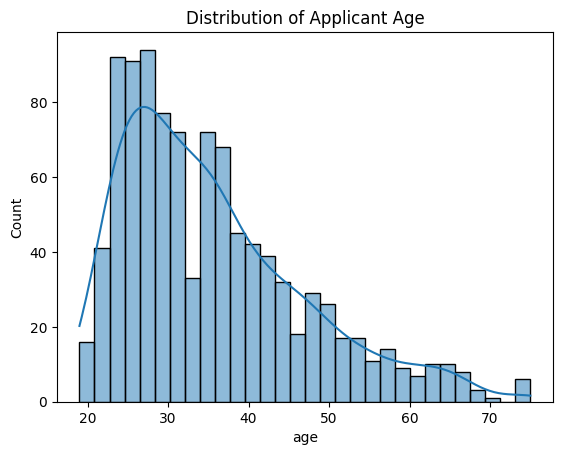

In [26]:
#Age Distribution
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Distribution of Applicant Age")
plt.show()


###Applicant age follows an approximately normal distribution with a slight right skew, suggesting a concentration of borrowers in the economically active age range.

*Bivariate Analysis*

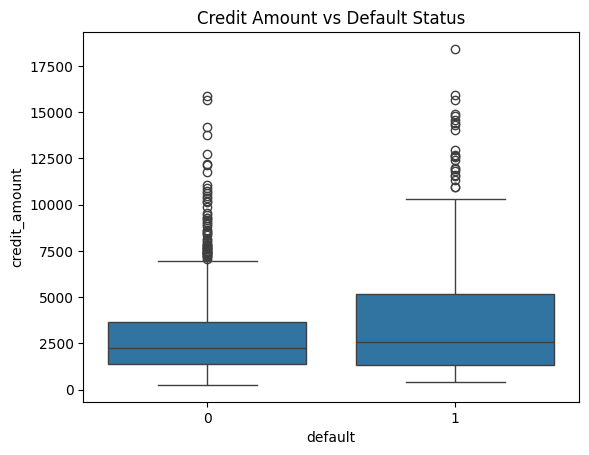

In [27]:
#Credit Amount vs Default
sns.boxplot(x="default", y="credit_amount", data=df)
plt.title("Credit Amount vs Default Status")
plt.show()


###Defaulted applicants tend to request higher credit amounts on average, indicating a positive association between loan size and default risk.

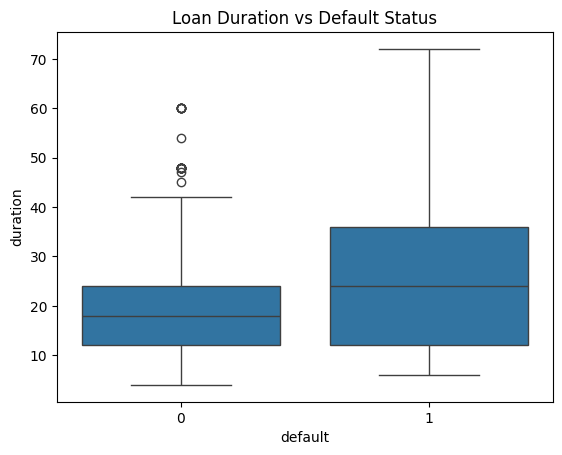

In [28]:
#Loan Duration vs Default
sns.boxplot(x="default", y="duration", data=df)
plt.title("Loan Duration vs Default Status")
plt.show()


Longer loan durations are associated with higher default rates, possibly due to increased exposure to income and employment uncertainty over time.

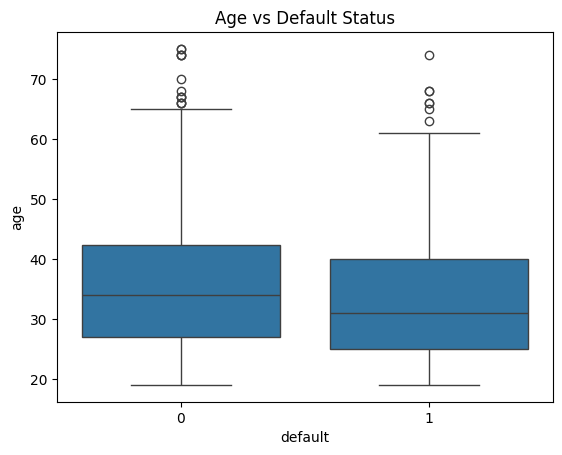

In [29]:
#Age vs Default
sns.boxplot(x="default", y="age", data=df)
plt.title("Age vs Default Status")
plt.show()

###Younger applicants exhibit a higher variability in default outcomes, whereas older applicants show relatively lower default risk, suggesting age as a stabilizing factor.

*Trivariate Analysis*

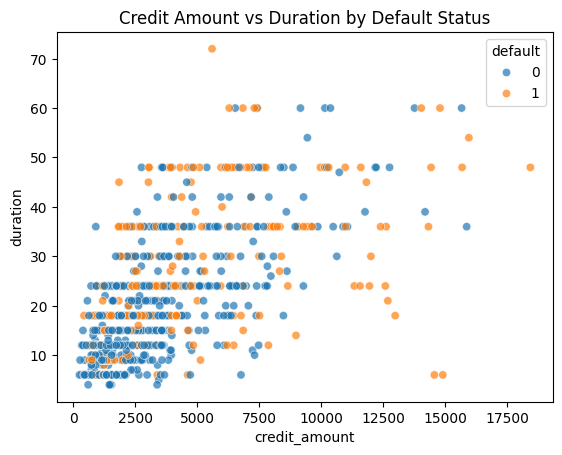

In [30]:
#Credit Amount × Duration × Default
sns.scatterplot(
    x="credit_amount",
    y="duration",
    hue="default",
    data=df,
    alpha=0.7
)
plt.title("Credit Amount vs Duration by Default Status")
plt.show()


###Default cases are more concentrated in regions combining higher credit amounts and longer loan durations, indicating an interaction effect between exposure size and repayment horizon.

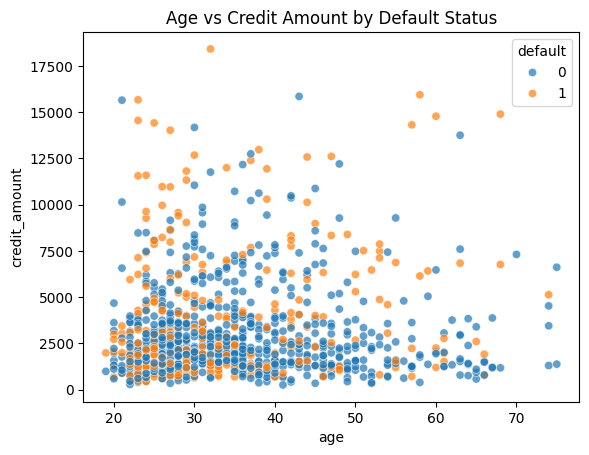

In [31]:
#Age × Credit Amount × Default
sns.scatterplot(
    x="age",
    y="credit_amount",
    hue="default",
    data=df,
    alpha=0.7
)
plt.title("Age vs Credit Amount by Default Status")
plt.show()


###Younger applicants requesting higher credit amounts appear to carry elevated default risk, whereas older applicants tend to default less even at comparable loan sizes.

In [32]:
#Employment × Credit History × Default
pd.crosstab(
    df["employment"],
    df["credit_history"],
    values=df["default"],
    aggfunc="mean"
)


credit_history,A30,A31,A32,A33,A34
employment,,,,,
A71,1.000000,0.600000,0.387097,0.500000,0.210526
A72,0.666667,0.666667,0.378378,0.666667,0.258065
A73,0.555556,0.400000,0.343915,0.181818,0.202381
A74,0.666667,0.600000,0.247191,0.176471,0.109091
A75,0.666667,0.700000,0.254545,0.400000,0.144231


###Applicants with weaker employment stability and adverse credit history exhibit significantly higher average default rates, reinforcing the importance of combined socio-economic indicators.

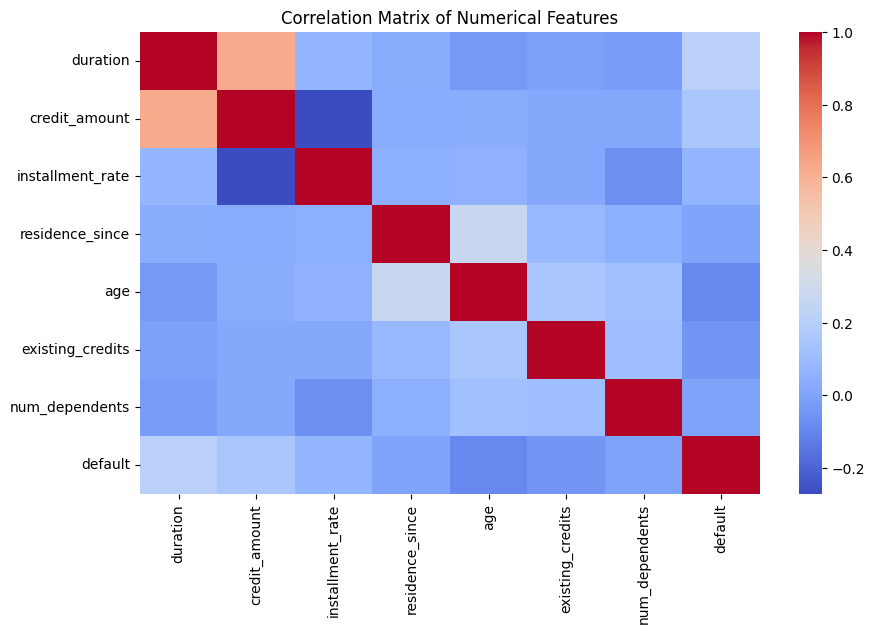

In [33]:
#Correlation Analysis
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(exclude="object").corr(), cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


###Moderate correlations are observed among financial exposure variables, while no severe multicollinearity is detected, supporting the use of tree-based models such as XGBoost.

**Module 2: Feature Enginnering**

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import pandas as pd

# 1. Defining Features and Target
X = df.drop("default", axis=1)
y = df["default"]

# 2. Spliting to avoid data lekage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# 3. Definig Preprocessor
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    verbose_feature_names_out=False # Keeps names clean (e.g., "housing_own" instead of "cat__housing_own")
)

# 4. Fit on Train, Transform Test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 5. Recover Feature Names (Crucial for SHAP)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

# 6. Applying SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_df, y_train)

print(f"Balanced Train Shape: {X_train_balanced.shape}")
print(f"Test Shape: {X_test_df.shape}")

Balanced Train Shape: (1050, 61)
Test Shape: (250, 61)


**Module 3 : Model Training and Evaluation with SHAP explainability**

### *importing ncessary libraries*


In [35]:
import pandas as pd
import joblib
import xgboost as xgb
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# The processed and balanced data is already available from previous cells:
# X_train_balanced, y_train_balanced, X_test_df, y_test

# Assign these to the variables expected by subsequent cells for consistency
X_train = X_train_balanced
y_train = y_train_balanced
X_test = X_test_df

# No need to read processed_data.csv or perform train_test_split again


In [51]:
import pandas as pd

# Combine the processed training and testing features
X_combined = pd.concat([X_train_balanced, X_test_df], axis=0)

# Combine the corresponding target variables
y_combined = pd.concat([y_train_balanced, y_test], axis=0)

# Ensure both X and y have the same index for correct concatenation
X_combined.index = range(len(X_combined))
y_combined.index = range(len(y_combined))

# Create the final cleaned dataset
cleaned_df = pd.concat([X_combined, y_combined], axis=1)

# Save the cleaned dataset to a CSV file
cleaned_df.to_csv("cleaned_data_for_powerbi.csv", index=False)

print("Cleaned dataset saved as 'cleaned_data_for_powerbi.csv' for Power BI tasks.")
print(f"Shape of the saved dataset: {cleaned_df.shape}")

Cleaned dataset saved as 'cleaned_data_for_powerbi.csv' for Power BI tasks.
Shape of the saved dataset: (1300, 62)


### *Hyperparameter Grid*

In [36]:
param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "gamma": [0, 0.1],
    "reg_lambda": [1, 5],

}


### *Grid Search with Cross-Validation*

In [37]:
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    enable_categorical=False
)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid, # Changed param_grid to param_distributions
    scoring="roc_auc",
    cv=10,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'gamma': [0, 0.1],
                                        'learning_rate': [0.03, 0.05],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [200, 300],
                                        'reg_lambda': [1, 5],
                                        'subsample': [0.8]},
                   scoring='roc_auc', verbose=1)

### *Best Parameters*


In [38]:
random_search.best_params_

{'subsample': 0.8,
 'reg_lambda': 1,
 'n_estimators': 200,
 'max_depth': 4,
 'learning_rate': 0.03,
 'gamma': 0,
 'colsample_bytree': 0.8}

### *Final Model Training (Using Best Params)*

In [39]:
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [40]:
#features name after encoding
feature_names = preprocessor.get_feature_names_out()

print("Total features after encoding:", len(feature_names))

Total features after encoding: 61


### *Model Evaluation*

In [41]:
y_prob = best_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, best_model.predict(X_test)))


ROC-AUC: 0.7942095238095238
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       175
           1       0.57      0.52      0.54        75

    accuracy                           0.74       250
   macro avg       0.68      0.67      0.68       250
weighted avg       0.73      0.74      0.73       250



### The tuned XGBoost model demonstrates improved discriminatory power compared to baseline configurations, validating the effectiveness of hyperparameter optimization.

### *SHAP Explainability (After Tuning)*

In [42]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)


### *Global Feature Importance*

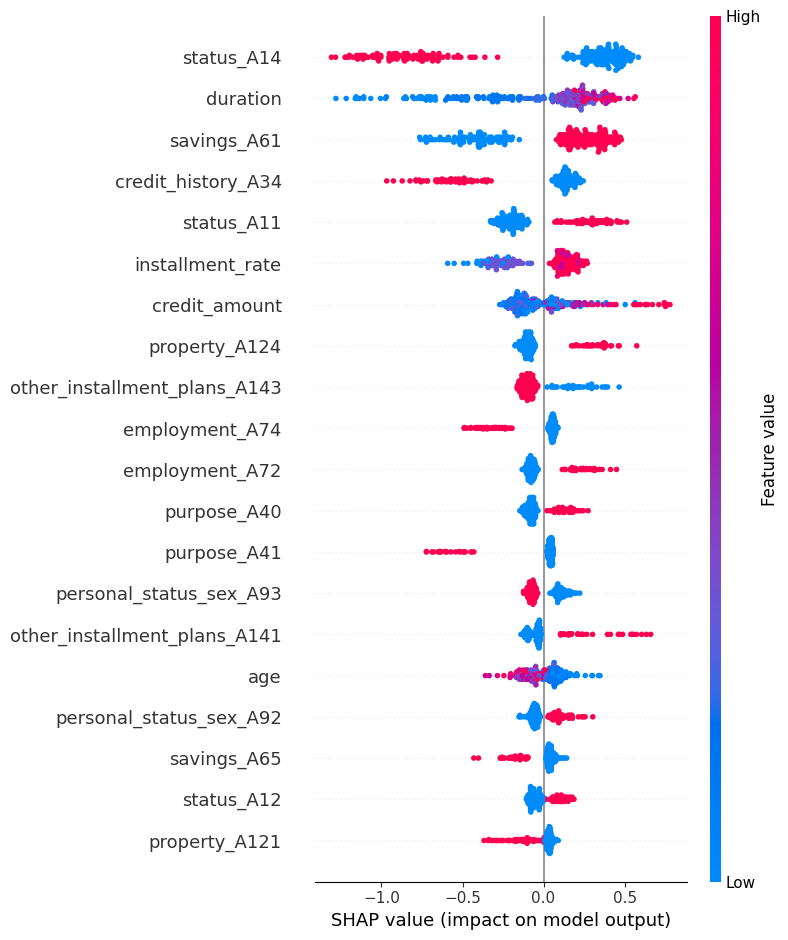

In [43]:
shap.summary_plot(shap_values, X_test)


### *Explicit BASE VALUE + DECISION CONTEXT*

In [44]:
base_value = explainer.expected_value
pred_value = shap_values[0].values.sum() + base_value

print(f"Base (Average) Default Risk: {base_value:.4f}")
print(f"Predicted Default Risk for Applicant: {pred_value:.4f}")


Base (Average) Default Risk: -0.3727
Predicted Default Risk for Applicant: 2.3355


### SHAP analysis highlights key financial and demographic attributes influencing default risk, providing transparent insight into the model’s decision-making process.

### *Local Explanation (Single Applicant)*

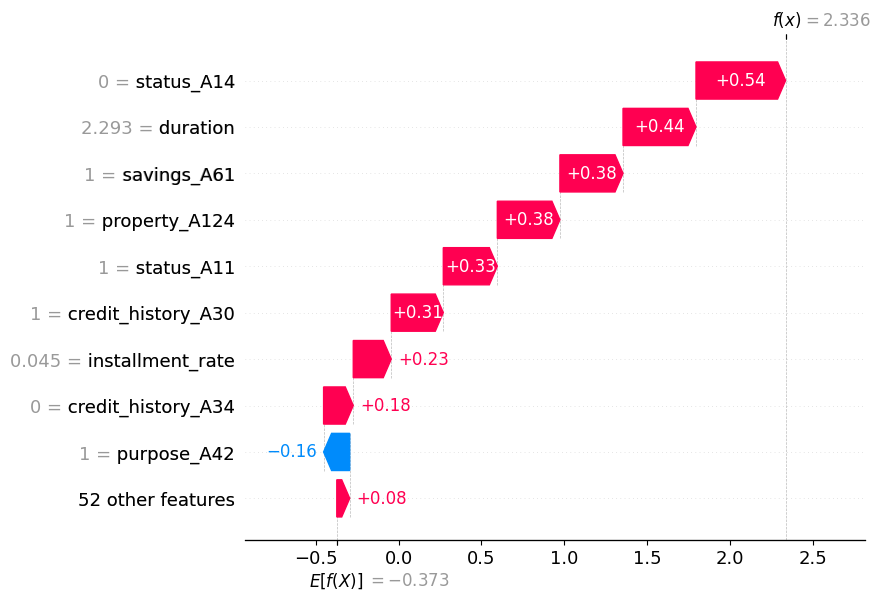

In [45]:
shap.plots.waterfall(shap_values[0])


###*TOP POSITIVE vs NEGATIVE CONTRIBUTORS*

In [46]:
import pandas as pd

local_shap = pd.DataFrame({
    "feature": X_test.columns,
    "shap_value": shap_values[0].values
})

local_shap["impact"] = local_shap["shap_value"].abs()
local_shap_sorted = local_shap.sort_values("impact", ascending=False)

local_shap_sorted.head(10)


,feature,shap_value,impact
10,status_A14,0.540649,0.540649
0,duration,0.440390,0.440390
26,savings_A61,0.380822,0.380822
46,property_A124,0.377634,0.377634
7,status_A11,0.326068,0.326068
11,credit_history_A30,0.314143,0.314143
2,installment_rate,0.229162,0.229162
15,credit_history_A34,0.178996,0.178996
19,purpose_A42,-0.157558,0.157558
52,housing_A153,-0.085474,0.085474


###The table above highlights the most influential features for the selected applicant. Features with positive SHAP values increase default risk, while negative values contribute toward creditworthiness. This tabular view complements the visual explanation and improves interpretability for non-technical stakeholders.

### *COMPARISON WITH NON-DEFAULT APPLICANTS*

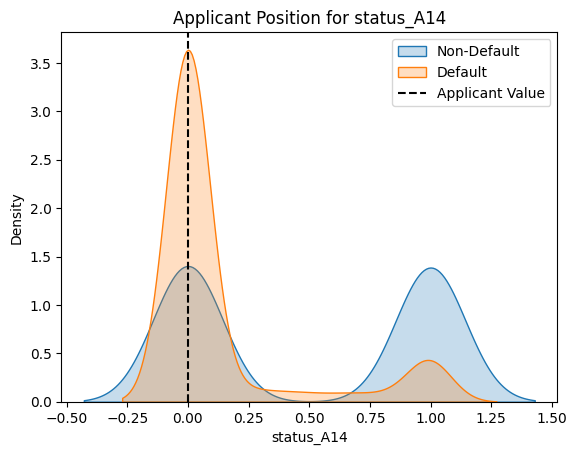

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

top_feature = local_shap_sorted.iloc[0]["feature"]

sns.kdeplot(
    X_train[top_feature][y_train == 0],
    label="Non-Default",
    fill=True
)

sns.kdeplot(
    X_train[top_feature][y_train == 1],
    label="Default",
    fill=True
)

plt.axvline(
    X_test.iloc[0][top_feature],
    color="black",
    linestyle="--",
    label="Applicant Value"
)

plt.title(f"Applicant Position for {top_feature}")
plt.legend()
plt.show()


### The applicant’s feature value is compared against the distributions of default and non-default cases. This contextualizes the local SHAP explanation by showing whether the applicant lies closer to historically risky or safe regions of the feature space.

### *DECISION JUSTIFICATION STATEMENT*

In [48]:
risk_drivers = local_shap_sorted.head(3)

for _, row in risk_drivers.iterrows():
    direction = "increases" if row["shap_value"] > 0 else "reduces"
    print(f"{row['feature']} {direction} default risk")


status_A14 increases default risk
duration increases default risk
savings_A61 increases default risk


### Based on the local explanation, the applicant’s risk profile is primarily influenced by a small number of high-impact features. These drivers provide a clear and auditable rationale for the credit decision, supporting transparency and regulatory review.

### *stability checking*

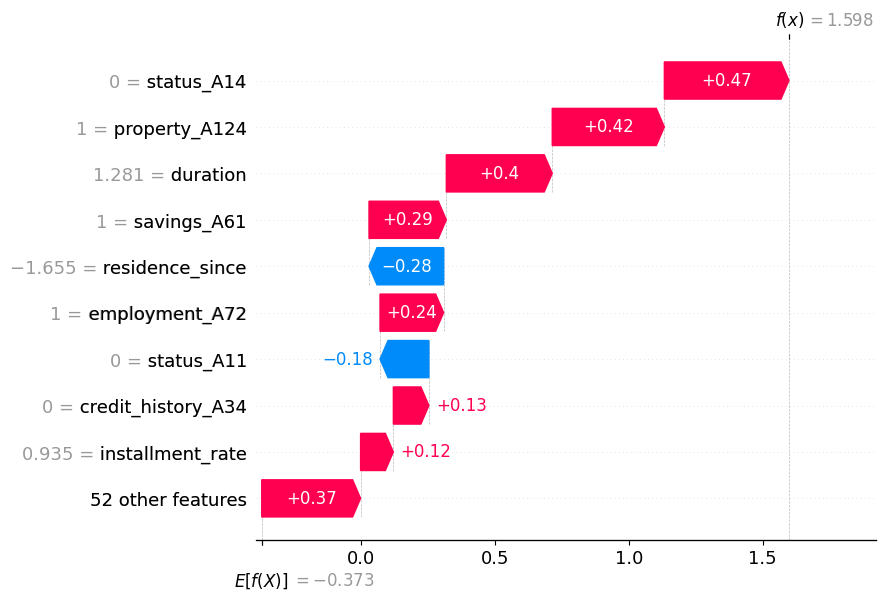

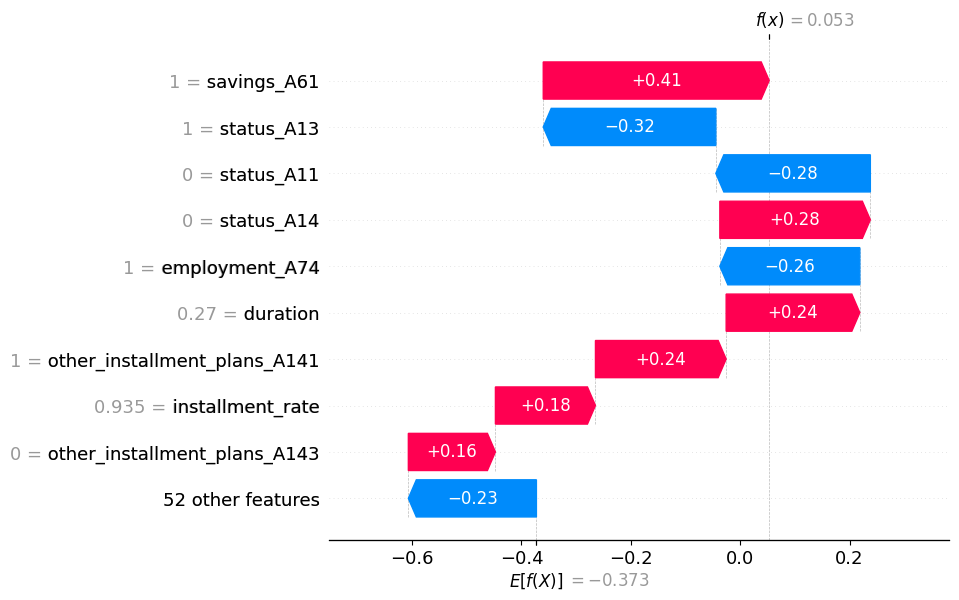

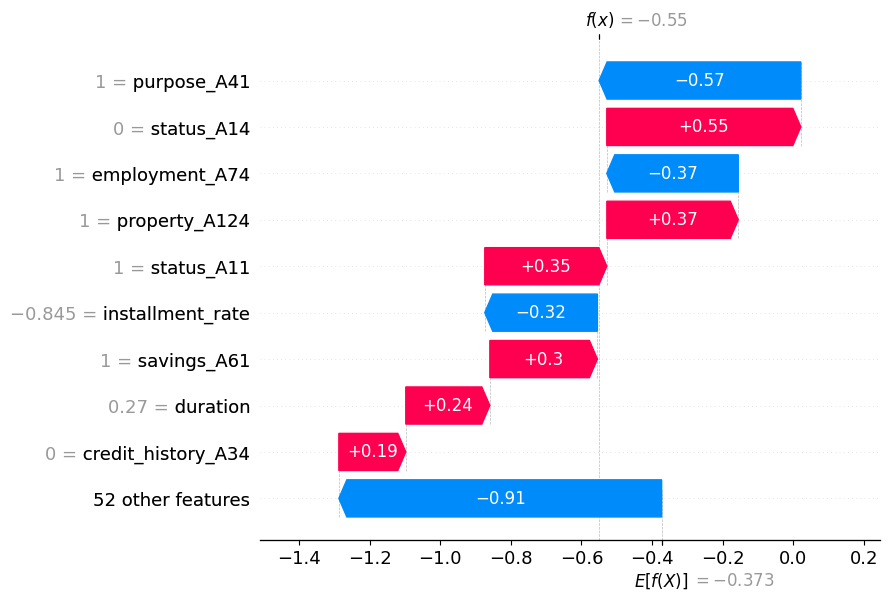

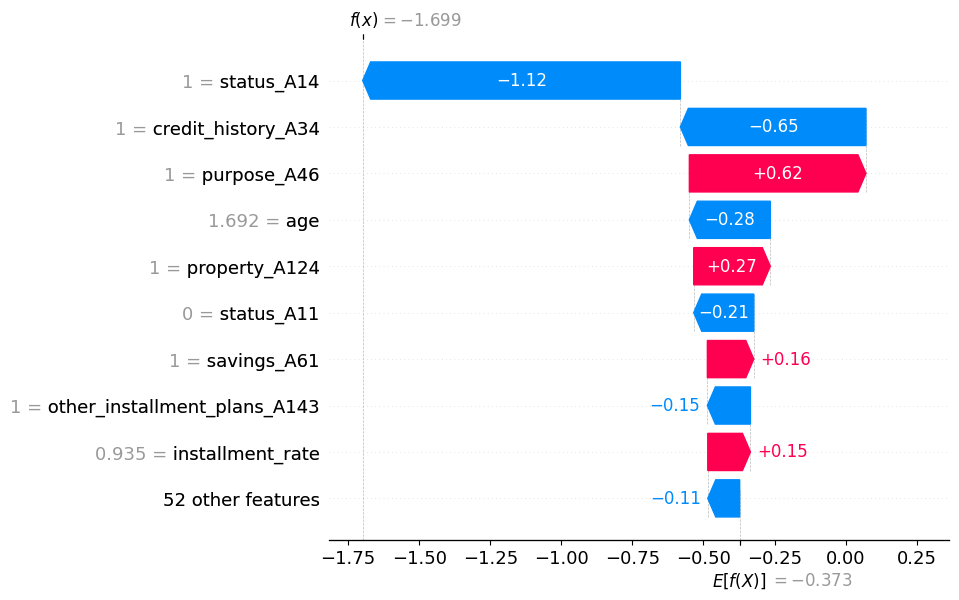

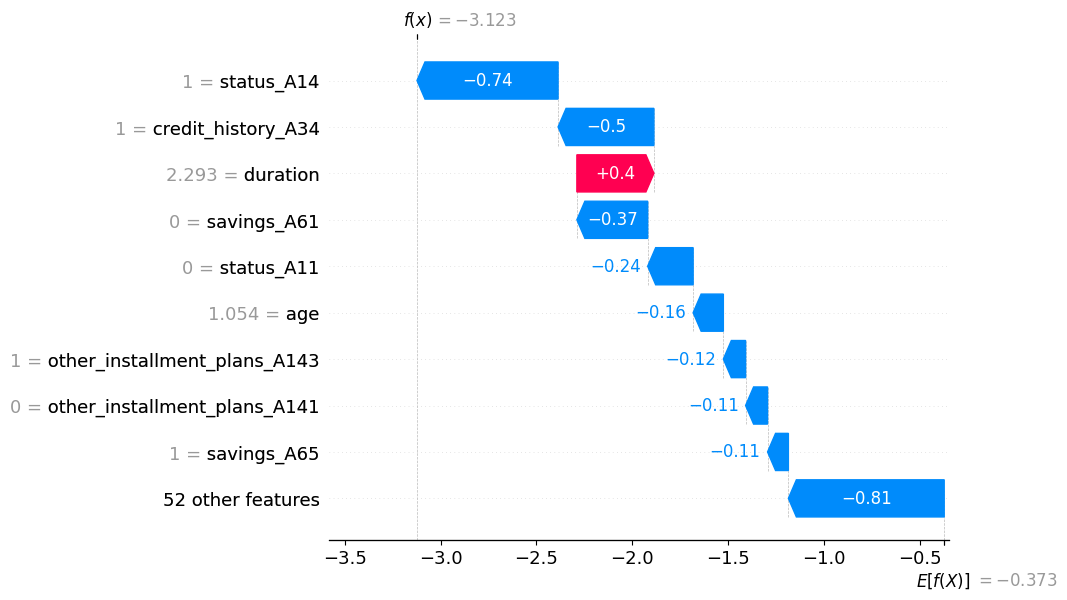

In [49]:
sample_indices = X_test.sample(5, random_state=42).index

for idx in sample_indices:
    shap.plots.waterfall(shap_values[list(X_test.index).index(idx)])


### Consistent explanation patterns across similar applicants indicate stable model behavior, which is desirable in regulated financial environments.

In [50]:
#final serialization
joblib.dump(best_model, "model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(explainer, "explainer.pkl")
joblib.dump(feature_names, "feature_names.pkl")

print("Model, preprocessor, explainer, and feature names dumped successfully.")


Model, preprocessor, explainer, and feature names dumped successfully.
